# Лабораторная работа 2. Методы обучения нейронных сетей

### Содержание
1. [Работа с данными](#Работа-с-данными)
1. [Построение модели](#Построение-модели)
1. [Исследование гиперпараметров](#Исследование-гиперпараметров)

В данной лабораторной работе потребуется исследовать эффективность различных приемов и методов обучения нейронных сетей:
* количество нейронов скрытого слоя;
* количество эпох обучения;
* функции активации;
* регуляризация;
* инициализация весов;
* нормализация по мини-батчам;
* методы градиентного спуска;
* адаптивные методы градиентного спуска.

### Работа с данными

Исследовать эти приемы и методы предлагается на [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) – наборе черно-белых рукописных цифр размером 28x28 пикселей:

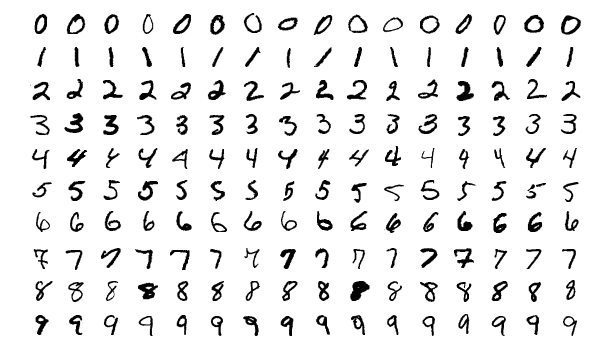

MNIST содержит 60 000 изображений для обучения и 10 000 изображений для тестирования.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(42)

---
Задаем гиперпараметры (некоторые из них нужно будет менять в процессе исследования):

In [4]:
input_size = 28 * 28 # 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

---
Код работы с данными (загрузка, предобработка, сэмплирование) должен быть отделен от кода работы с моделями (создание, обучение, тестирование).  
PyTorch предоставляет два класса для работы с данными: `Dataset` и `DataLoader`:  
- класс [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) позволяет загружать и хранить как предустановленные наборы данных (например, MNIST), так и свои собственные;
- класс [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) позволяет осуществлять доступ к данным в процессе обучения.  

В PyTorch есть множество предустановленных наборов данных:
- [текстов](https://pytorch.org/text/stable/datasets.html);
- [изображений](https://pytorch.org/vision/stable/datasets.html);
- [аудио](https://pytorch.org/audio/stable/datasets.html).

Ниже приведен код загрузки MNIST:

In [5]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

---
Список всех классов в `Dataset`:

In [7]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

К примерам в `Dataset` можно обращаться по индексу. Выведем, например, метку самого первого примера:

In [8]:
print(f'Label of the first example is {train_dataset[0][1]}.')

Label of the first example is 5.


---
Цифры можно нарисовать:

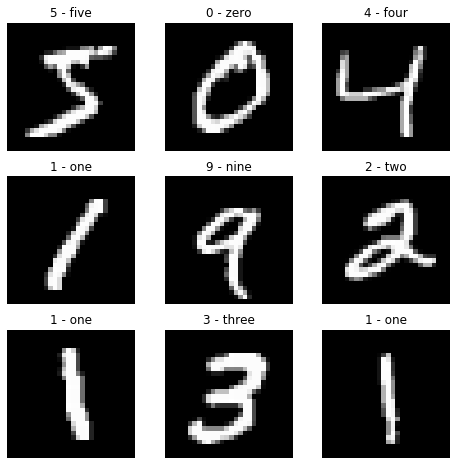

In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = train_dataset[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

При загрузке мы применили [преобразование данных](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html): `transform=transforms.ToTensor()` осуществляет преобразование чисел в тензоры и нормирует к диапазону [0, 1].  
Также можно применять преобразования к меткам (например, переводить индекс в *OneHot Encoding*), для этого служит параметр `target_transform`.

---
#### Терминология  
- *Батч (batch)* – подмножество обучающих данных, которое подается на сеть в процессе обучения. после чего веса сети обновляются.  
    - `batch_size = len(train_dataset)` – Vanilla Gradient Descent или Batch Gradient Descent
    - `batch_size = 1` – Stochastic Gradient Descent
    - `1 < batch_size < len(train_dataset)` – Mini-Batch Gradient Descent
- *Шаг (step)* – период обработки одного батча.  
- *Эпоха (epoch)* – период обработки всего обучающего множества; количество шагов в эпохе равно количеству батчей в обучающем множестве. 

---
Для подготовки данных для обучения служит класс `DataLoader`. Он позволяет случайным образом формировать мини-батчи и перемешивать данные перед каждой эпохой обучения.  
Зададим объекты `DataLoader` на основе MNIST:

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [11]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

---
По объектам `DataLoader` можно осуществлять итерацию; при этом на каждом шаге будет возвращаться подмножество размером `batch_size`:

In [12]:
print(f'Number of batches = {len(train_loader)}')

train_data, train_labels = next(iter(train_loader))
print(f'Size of the batch = {len(train_data)}')

print(f'Number of all the samples = {len(train_loader) * len(train_data)}')

Number of batches = 600
Size of the batch = 100
Number of all the samples = 60000


In [21]:
print(f'Number of batches = {len(test_loader)}')

test_data, test_labels = next(iter(test_loader))
print(f'Size of the batch = {len(test_data)}')

print(f'Number of all the samples = {len(test_loader) * len(test_data)}')

Number of batches = 100
Size of the batch = 100
Number of all the samples = 10000


После того, как все батчи будут выданы (по окончании эпохи обучения), в случае, если `shuffle=True`, произойдет перемешивание данных и на следующей эпохе батчи будут уже другими.

### Построение модели

#### Задание.  
Опишите класс `NeuralNetwork` для распознавания MNIST: двухслойная нейронная сеть прямого распространения, количество нейронов скрытого слоя – `hidden_size`, функция активации скрытого слоя – `ReLU`. Выходной слой пусть остается линейным, без функции активации.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        y = self.layer1(x)
        y = self.relu(y)
        y = self.layer2(y)
        return y

#### Задание.  
Создайте объект класса `NeuralNetwork`, перенесите его на GPU.  
Задайте функцию потерь (например, `CrossEntropyLoss`) и любой оптимизатор.

In [14]:
model = NeuralNetwork()
model.to(device)
model

NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=500, out_features=10, bias=True)
)

In [15]:
loss_fn = nn.CrossEntropyLoss()

---
Напишем цикл обучения для нашей сети:

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
start_time = time()
losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        sumloss = 0
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        #losses.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            losses.append(loss.item())
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            
print(f'Time = {time() - start_time:.1f}')

Epoch [1/5], Step [100/600], Loss: 2.2943
Epoch [1/5], Step [200/600], Loss: 2.2720
Epoch [1/5], Step [300/600], Loss: 2.2414
Epoch [1/5], Step [400/600], Loss: 2.2039
Epoch [1/5], Step [500/600], Loss: 2.2027
Epoch [1/5], Step [600/600], Loss: 2.1833
Epoch [2/5], Step [100/600], Loss: 2.1446
Epoch [2/5], Step [200/600], Loss: 2.1272
Epoch [2/5], Step [300/600], Loss: 2.1033
Epoch [2/5], Step [400/600], Loss: 2.0609
Epoch [2/5], Step [500/600], Loss: 2.0581
Epoch [2/5], Step [600/600], Loss: 2.0064
Epoch [3/5], Step [100/600], Loss: 2.0209
Epoch [3/5], Step [200/600], Loss: 1.9584
Epoch [3/5], Step [300/600], Loss: 1.9267
Epoch [3/5], Step [400/600], Loss: 1.8841
Epoch [3/5], Step [500/600], Loss: 1.8205
Epoch [3/5], Step [600/600], Loss: 1.8370
Epoch [4/5], Step [100/600], Loss: 1.7628
Epoch [4/5], Step [200/600], Loss: 1.7945
Epoch [4/5], Step [300/600], Loss: 1.7172
Epoch [4/5], Step [400/600], Loss: 1.6900
Epoch [4/5], Step [500/600], Loss: 1.7174
Epoch [4/5], Step [600/600], Loss:

#### Задание.  
Постройте график зависимости потерь на мини-батче от шага обучения.

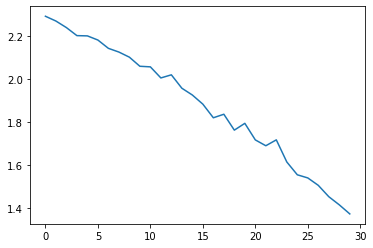

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses)

---
Получим предсказания модели на тестовых данных:

In [22]:
import numpy as np
import pandas as pd

In [23]:
pred_all = np.array([])
labels_all = np.array([])
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        pred_all = np.append(pred_all, predicted.cpu().detach().numpy())
        labels_all = np.append(labels_all, labels.cpu().detach().numpy())

print(f'last predict = {predicted[-1]}, true label = {labels[-1]}')

last predict = 6, true label = 6


In [24]:
len(pred_all)

10000

#### Задание.  
Вычислите правильность (Accuracy) модели на тестовых данных.

In [25]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(pred_all, labels_all)
acc

0.7806

---
Сохраним полученную модель:

In [26]:
torch.save(model.state_dict(), 'model.ckpt')

### Исследование гиперпараметров

#### Задание. 

Подберите гиперпараметры нейронной сети, обеспечивающие наилучшее качество классификации тестовых данных MNIST.  
Требуется исследовать следующие гиперпараметры:
* количество нейронов скрытого слоя – не менее 5 вариантов;
* количество эпох обучения – не менее 3 вариантов;
* функции активации – не менее 3 вариантов (симметричные и несимметричные);
* регуляризация – weight decay (L2) и dropout;
* инициализация весов (Xavier и Kaiming);
* нормализация по мини-батчам (наличие/отсутствие);
* методы градиентного спуска (SGD, momentum SGD, Nesterov SGD);
* адаптивные методы градиентного спуска (AdaGrad, AdaDelta, RMSProp, Adam, AdamW).

Необязательно выполнять полный перебор – можно осуществить жадный поиск.  

Результаты подбора вывести в удобном виде.  

Для всех вариантов градиентного спуска нарисовать графики процесса обучения.  


In [27]:
input_size = 28 * 28 # 784
#hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001
weight_decay = 0.001
p_dropout = 0.2
init_func = 'None'

In [28]:
arr_hidden_size = [100, 200, 300, 400, 500]
arr_epoch_value = [5, 7, 9]
arr_activation_func = ['sigmoid', 'tanh', 'relu']
arr_regularization = ['weight_decay_L2', 'dropout']
arr_weight_init = ['xavier', 'kaiming'] # xvvier для симметричных, kaming для не семмитричных
arr_normalization_mini_batch = [True, False]
arr_learning = ['SGD', 'MomentumSGD', 'NesterovSGD', 'AdaGrad', 'AdaDelta', 'RMSProp', 'Adam'] #'AdamW'
#1260

In [29]:
best_params = {
    'accuracy' : 0,
    'hidden_size' : None,
    'epoch_value' : None,
    'activation_func' : None,
    'regularization' : None,
    'weight_init' : None,
    'normalization_mini_batch' : None,
    'optimizer' : None,
}

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Замечание**. Напомним, что в этом случае тестовый набор MNIST играет роль валидационного набора, так как подбор оптимальных значений гиперапараметров на тестовых данных может приводить к переобучению!

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size, activation_function, dropout=False, batchnorm=False):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
        self.activation = activation_function
        self.batchnorm1d = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p_dropout)
        self.dropout_flag=dropout
        self.batchnorm_flag=batchnorm
        
    def forward(self, x):
        x = self.hidden(x)
        if self.batchnorm_flag:
            x = self.batchnorm1d(x)
        if self.dropout_flag:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [103]:
def get_optimizer(model, optim, wdecay=0):
    if optim == 'SGD':
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wdecay)
    elif optim == 'MomentumSGD':
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=wdecay)
    elif optim == 'NesterovSGD':
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=wdecay)
    elif optim == 'AdaGrad':
        optim = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=wdecay)
    elif optim == 'AdaDelta':
        optim = torch.optim.Adadelta(model.parameters(), lr=0.01, weight_decay=wdecay)
    elif optim == 'RMSProp':
        optim = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=wdecay)
    elif optim == 'Adam':
        optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wdecay)
    return optim

In [33]:
def get_activation_function(af):
    if af == 'sigmoid':
        return torch.sigmoid
    elif af == 'tanh':
        return torch.tanh
    elif af == 'relu':
        return torch.relu
    return torch.relu

In [34]:
def with_dropout(q):
    return True if q == 'dropout' else False

In [35]:
def with_weight_decay(q):
    return weight_decay if q == 'weight_decay_L2' else 0

In [36]:
def init_weights(m):
    if type(m) == nn.Linear:
        if init_func == 'xavier':
            torch.nn.init.xavier_uniform_(m.weight, gain=1)
        elif init_func == 'kaiming':
            torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')    
        m.bias.data.fill_(0.01)

In [37]:
def get_accuracy(m):
    from sklearn.metrics import accuracy_score
    pred_all = np.array([])
    labels_all = np.array([])
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = m(images)
            max_values, predicted = torch.max(outputs.data, 1)
            pred_all = np.append(pred_all, predicted.cpu().detach().numpy())
            labels_all = np.append(labels_all, labels.cpu().detach().numpy())
    acc = accuracy_score(pred_all, labels_all)
    return acc

In [38]:
def learning(model, op, wd, n_epochs):
    optimizer = get_optimizer(model, op, wdecay=wd)
    loss_fn = nn.CrossEntropyLoss()
    #losses = []
    total_step = len(train_loader)
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if (i+1) % 100 == 0:
                #losses.append(loss.item())
    return get_accuracy(model)

In [124]:
from tqdm.notebook import tqdm
t = len(arr_hidden_size) * len(arr_epoch_value) * len(arr_activation_func) * len(arr_regularization) * len(arr_normalization_mini_batch) * len(arr_learning)
pbar = tqdm(total=t)
for hiddensize in arr_hidden_size:
    for epochvalue in arr_epoch_value:
        for activationfunc in arr_activation_func: # sigmoid/tanh/relu
            # xavier/kaiming
            if activationfunc in ['sigmoid', 'tanh']:
                init_func = 'xavier'
            elif activationfunc == 'relu':
                init_func = 'kaiming'
            for regularization in arr_regularization: # weight_decay or dropout
                for norm_minibatch in arr_normalization_mini_batch: # true or false
                    for opt in arr_learning:
                        pbar.update(1)
                        model = NeuralNetwork(
                            hiddensize, 
                            get_activation_function(activationfunc),
                            dropout=with_dropout(regularization), 
                            batchnorm=norm_minibatch
                        )
                        model.to(device)
                        model.apply(init_weights)
                        accuracy = learning(model, opt, with_weight_decay(regularization), epochvalue)
                        if accuracy > best_params['accuracy']:
                            best_params = {
                                'accuracy' : accuracy,
                                'hidden_size' : hiddensize,
                                'epoch_value' : epochvalue,
                                'activation_func' : activationfunc,
                                'regularization' : regularization,
                                'weight_init' : init_func,
                                'normalization_mini_batch' : norm_minibatch,
                                'optimizer' : opt,
                            }
                            print('Update\n', best_params)
pbar.close()

Update
 {'accuracy': 0.7835, 'hidden_size': 100, 'epoch_value': 5, 'activation_func': 'sigmoid', 'regularization': 'weight_decay_L2', 'weight_init': 'xavier', 'normalization_mini_batch': True, 'optimizer': 'SGD'}
Update
 {'accuracy': 0.8984, 'hidden_size': 100, 'epoch_value': 5, 'activation_func': 'sigmoid', 'regularization': 'weight_decay_L2', 'weight_init': 'xavier', 'normalization_mini_batch': True, 'optimizer': 'MomentumSGD'}
Update
 {'accuracy': 0.8989, 'hidden_size': 100, 'epoch_value': 5, 'activation_func': 'sigmoid', 'regularization': 'weight_decay_L2', 'weight_init': 'xavier', 'normalization_mini_batch': True, 'optimizer': 'NesterovSGD'}
Update
 {'accuracy': 0.9274, 'hidden_size': 100, 'epoch_value': 5, 'activation_func': 'sigmoid', 'regularization': 'weight_decay_L2', 'weight_init': 'xavier', 'normalization_mini_batch': True, 'optimizer': 'RMSProp'}
Update
 {'accuracy': 0.94, 'hidden_size': 100, 'epoch_value': 5, 'activation_func': 'sigmoid', 'regularization': 'weight_decay_L

### Оптимальыне параметры сети

- Accuracy: 0.9819
- Hidden size: 500
- Epoches: 9
- Activation function: ReLU
- Regularization: dropout
- Weight init: Kaiming
- Normalization mini batch: False
- Optimizer: RMSprop

In [39]:
best_params

{'accuracy': 0,
 'hidden_size': None,
 'epoch_value': None,
 'activation_func': None,
 'regularization': None,
 'weight_init': None,
 'normalization_mini_batch': None,
 'optimizer': None}

### Подбор оптимальных параметров для каждого оптимизатора

In [40]:
arr_hidden_size = [100, 200, 300, 400, 500]
arr_epoch_value = [5, 7, 9]
arr_activation_func = ['sigmoid', 'tanh', 'relu']
arr_regularization = ['weight_decay_L2', 'dropout']
arr_weight_init = ['xavier', 'kaiming'] # xvvier для симметричных, kaming для не семмитричных
arr_normalization_mini_batch = [True, False]
arr_learning = ['SGD', 'MomentumSGD', 'NesterovSGD', 'AdaGrad', 'AdaDelta', 'RMSProp', 'Adam'] #'AdamW'

In [41]:
def find_params(opt):
    s_best_params = { 'accuracy' : 0 }
    t = len(arr_hidden_size) * len(arr_epoch_value) * len(arr_regularization) * len(arr_normalization_mini_batch)
    pbar = tqdm(total=t)
    for hiddensize in arr_hidden_size:
        for epochvalue in arr_epoch_value:
            activationfunc = 'relu'
            init_func = 'kaiming'
            for regularization in arr_regularization: # weight_decay or dropout
                for norm_minibatch in arr_normalization_mini_batch: # true or false
                    pbar.update(1)
                    model = NeuralNetwork(
                        hiddensize, 
                        get_activation_function(activationfunc),
                        dropout=with_dropout(regularization), 
                        batchnorm=norm_minibatch
                    )
                    model.to(device)
                    model.apply(init_weights)
                    accuracy = learning(model, opt, with_weight_decay(regularization), epochvalue)
                    if accuracy > s_best_params['accuracy']:
                        s_best_params = {
                            'accuracy' : accuracy,
                            'hidden_size' : hiddensize,
                            'epoch_value' : epochvalue,
                            'activation_func' : activationfunc,
                            'regularization' : regularization,
                            'weight_init' : init_func,
                            'normalization_mini_batch' : norm_minibatch,
                            'optimizer' : opt,
                        }
                        #print('Update\n', s_best_params)
    pbar.close()
    return s_best_params

In [165]:
pbar = tqdm(total=7)
optimizers_best_params = {'SGD':None, 'MomentumSGD':None, 'NesterovSGD':None, 'AdaGrad':None, 'AdaDelta':None, 'RMSProp':None, 'Adam':None}
for op in arr_learning:
    pbar.update(1)
    tmp = find_params(op)
    print(tmp)
    optimizers_best_params[op] = tmp
pbar.close()


{'accuracy': 0.9095, 'hidden_size': 400, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'weight_decay_L2', 'weight_init': 'kaiming', 'normalization_mini_batch': True, 'optimizer': 'SGD'}



{'accuracy': 0.9552, 'hidden_size': 500, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'weight_decay_L2', 'weight_init': 'kaiming', 'normalization_mini_batch': True, 'optimizer': 'MomentumSGD'}



{'accuracy': 0.9546, 'hidden_size': 500, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'weight_decay_L2', 'weight_init': 'kaiming', 'normalization_mini_batch': True, 'optimizer': 'NesterovSGD'}



{'accuracy': 0.9547, 'hidden_size': 500, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'weight_decay_L2', 'weight_init': 'kaiming', 'normalization_mini_batch': True, 'optimizer': 'AdaGrad'}



{'accuracy': 0.8853, 'hidden_size': 500, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'weight_decay_L2', 'weight_init': 'kaiming', 'normalization_mini_batch': True, 'optimizer': 'AdaDelta'}



{'accuracy': 0.9803, 'hidden_size': 400, 'epoch_value': 9, 'activation_func': 'relu', 'regularization': 'dropout', 'weight_init': 'kaiming', 'normalization_mini_batch': False, 'optimizer': 'RMSProp'}



{'accuracy': 0.9781, 'hidden_size': 500, 'epoch_value': 7, 'activation_func': 'relu', 'regularization': 'dropout', 'weight_init': 'kaiming', 'normalization_mini_batch': False, 'optimizer': 'Adam'}



In [ ]:
optimizers_best_params

### Оптимальные параметры для каждого оптимизатора

In [170]:
optim_params = pd.DataFrame(optimizers_best_params)
optim_params.to_csv('optim_paramsss.csv')
optim_params

,SGD,MomentumSGD,NesterovSGD,AdaGrad,AdaDelta,RMSProp,Adam
accuracy,0.9095,0.9552,0.9546,0.9547,0.8853,0.9803,0.9781
hidden_size,400,500,500,500,500,400,500
epoch_value,9,9,9,9,9,9,7
activation_func,relu,relu,relu,relu,relu,relu,relu
regularization,weight_decay_L2,weight_decay_L2,weight_decay_L2,weight_decay_L2,weight_decay_L2,dropout,dropout
weight_init,kaiming,kaiming,kaiming,kaiming,kaiming,kaiming,kaiming
normalization_mini_batch,True,True,True,True,True,False,False
optimizer,SGD,MomentumSGD,NesterovSGD,AdaGrad,AdaDelta,RMSProp,Adam


### Графики обучения

In [96]:
def learning_mem(model, op, num_epochs, log=False):
    optimizer = op
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            #losses.append(loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                if log: print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
                losses.append(loss.item())
    return (get_accuracy(model), losses)

In [89]:
model2 = NeuralNetwork(
            500, 
            get_activation_function('relu'),
            dropout=True, 
            batchnorm=False
            )
model2.to(device)
model2.apply(init_weights)

NeuralNetwork(
  (hidden): Linear(in_features=784, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=10, bias=True)
  (batchnorm1d): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [90]:
def print_weights(model):
    for parameter in model.named_parameters():
        print(f'{parameter[0]} = {parameter[1].data}')

In [91]:
def check_device(model):
    for parameter in model.named_parameters():
        print(f'{parameter[0]} on Cuda: {parameter[1].data.is_cuda}')

In [92]:
check_device(model2)

hidden.weight on Cuda: True
hidden.bias on Cuda: True
output.weight on Cuda: True
output.bias on Cuda: True
batchnorm1d.weight on Cuda: True
batchnorm1d.bias on Cuda: True


In [93]:
def draw(data):
    plt.plot(data)
    plt.ylabel('error')
    plt.xlabel('epoches')
    plt.show()

In [94]:
import copy
n_ep = 9

Epoch [1/9], Step [100/600], Loss: 2.2773
Epoch [1/9], Step [200/600], Loss: 2.2592
Epoch [1/9], Step [300/600], Loss: 2.2466
Epoch [1/9], Step [400/600], Loss: 2.2002
Epoch [1/9], Step [500/600], Loss: 2.2123
Epoch [1/9], Step [600/600], Loss: 2.1713
Epoch [2/9], Step [100/600], Loss: 2.1429
Epoch [2/9], Step [200/600], Loss: 2.1146
Epoch [2/9], Step [300/600], Loss: 2.0969
Epoch [2/9], Step [400/600], Loss: 2.0462
Epoch [2/9], Step [500/600], Loss: 2.0579
Epoch [2/9], Step [600/600], Loss: 1.9805
Epoch [3/9], Step [100/600], Loss: 1.9747
Epoch [3/9], Step [200/600], Loss: 1.8962
Epoch [3/9], Step [300/600], Loss: 1.9329
Epoch [3/9], Step [400/600], Loss: 1.8744
Epoch [3/9], Step [500/600], Loss: 1.8228
Epoch [3/9], Step [600/600], Loss: 1.7409
Epoch [4/9], Step [100/600], Loss: 1.7954
Epoch [4/9], Step [200/600], Loss: 1.7448
Epoch [4/9], Step [300/600], Loss: 1.7146
Epoch [4/9], Step [400/600], Loss: 1.6821
Epoch [4/9], Step [500/600], Loss: 1.6366
Epoch [4/9], Step [600/600], Loss:

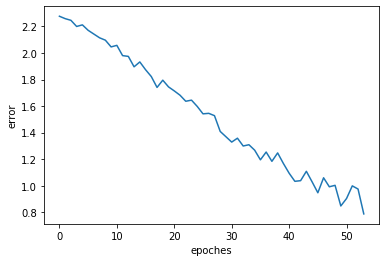

In [95]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'SGD')
accu, data = learning_mem(local_model, opt, n_ep, log=True)
print(accu)
draw(data)

0.9147


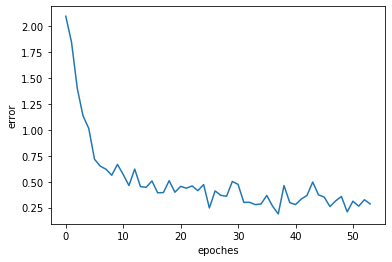

In [97]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'MomentumSGD')
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

0.916


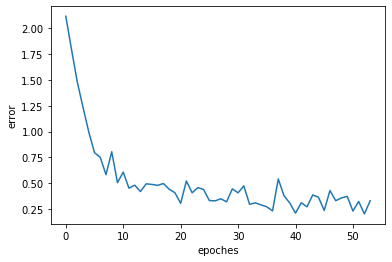

In [98]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'NesterovSGD')
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

0.9245


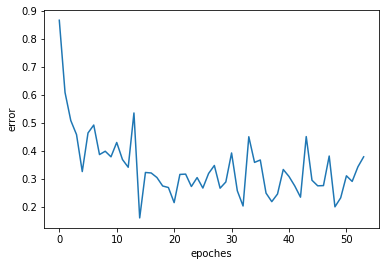

In [99]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'AdaGrad')
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

0.9155


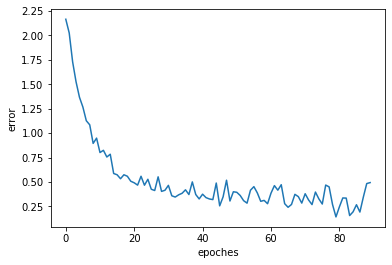

In [104]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'AdaDelta')
accu, data = learning_mem(local_model, opt, 15)
print(accu)
draw(data)

In [ ]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'RMSProp')
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

In [ ]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'Adam')
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

In [ ]:
local_model = copy.deepcopy(model2)
opt = get_optimizer(local_model, 'Adam',weight_decay)#AdamW
accu, data = learning_mem(local_model, opt, n_ep)
print(accu)
draw(data)

#### Задания (факультативные).
1. Прочитать параграф 3.6 в учебнике С. Николенко и др. (стр. 123–135) и воспроизвести рассмотренные там нейронные сети на TensorFlow.
1. Воспроизвести пример на Keras на стр. 147–149.
1. Воспроизвести пример на TensorFlow на стр. 158–159.